In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


In [108]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

# подгружаем данные и смотрим на них

In [109]:
# решаем проблему с кодировкой
data = pd.read_csv('complete laptop data0.csv',encoding='unicode_escape')
data.head()

,Unnamed: 0,link,name,user rating,Price,Sales Package,Model Number,Part Number,Model Name,Series,...,Security Chip,Inbuilt 4G LTE,Cloud Storage,S-video,Dock Port,Firewire Port,RJ11,Read/Write Speed,EMMC Storage Capacity,Optane Memory
0,0,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 17 Core i9 12th Gen - (32 ...,5.00,"?2,34,990","Laptop, Power Adaptor, User Guide, Warranty Do...",G733ZW-LL139WS,90NR08G2-M007S0,G733ZW-LL139WS,ROG Strix SCAR 17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 15 Core i9 12th Gen - (32 ...,NaN,"?2,29,990","Laptop, Power Adaptor, User Guide, Warranty Do...",G533ZW-LN136WS,90NR0872-M007L0,G533ZW-LN136WS,ROG Strix SCAR 15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,https://www.flipkart.com/hp-victus-ryzen-7-oct...,HP Victus Ryzen 7 Octa Core 5800H - (16 GB/512...,NaN,"?1,04,091","Laptop, battery, adapter, cables and user manuals",16-e0351AX,552X1PA#ACJ,16-e0351AX,Victus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,https://www.flipkart.com/lenovo-ideapad-gaming...,Lenovo IdeaPad Gaming 3i Ryzen 7 Octa Core R7-...,NaN,"?87,717","Laptop, Power Adaptor, User Guide, Warranty Do...",15ACH6,82K201RSIN,IdeaPad Gaming 3,IdeaPad Gaming 3i,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,https://www.flipkart.com/lenovo-yoga-slim-7-co...,Lenovo Yoga Slim 7 Core i5 11th Gen - (16 GB/5...,NaN,"?75,990","Laptop, Adaptor",82A300MBIN,1LS2B001653,Yoga Slim 7 14ITL05,Yoga Slim 7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
data.shape

(984, 98)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 98 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         984 non-null    int64  
 1   link                               984 non-null    object 
 2   name                               984 non-null    object 
 3   user rating                        690 non-null    float64
 4   Price                              984 non-null    object 
 5   Sales Package                      984 non-null    object 
 6   Model Number                       984 non-null    object 
 7   Part Number                        984 non-null    object 
 8   Model Name                         709 non-null    object 
 9   Series                             787 non-null    object 
 10  Color                              984 non-null    object 
 11  Type                               984 non-null    object 

In [112]:
#Само имя нам мало что дает, потому что в целом оно уникально. Но в нем зашито имя вендора. Попробуем выделить вендора из имени
data['Vendor']=data.name.str.split(" ",expand=True)[0]
data.insert(0, 'Vendor', data.pop('Vendor'))
data.head()

,Vendor,Unnamed: 0,link,name,user rating,Price,Sales Package,Model Number,Part Number,Model Name,...,Security Chip,Inbuilt 4G LTE,Cloud Storage,S-video,Dock Port,Firewire Port,RJ11,Read/Write Speed,EMMC Storage Capacity,Optane Memory
0,ASUS,0,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 17 Core i9 12th Gen - (32 ...,5.00,"?2,34,990","Laptop, Power Adaptor, User Guide, Warranty Do...",G733ZW-LL139WS,90NR08G2-M007S0,G733ZW-LL139WS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASUS,1,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 15 Core i9 12th Gen - (32 ...,NaN,"?2,29,990","Laptop, Power Adaptor, User Guide, Warranty Do...",G533ZW-LN136WS,90NR0872-M007L0,G533ZW-LN136WS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HP,2,https://www.flipkart.com/hp-victus-ryzen-7-oct...,HP Victus Ryzen 7 Octa Core 5800H - (16 GB/512...,NaN,"?1,04,091","Laptop, battery, adapter, cables and user manuals",16-e0351AX,552X1PA#ACJ,16-e0351AX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Lenovo,3,https://www.flipkart.com/lenovo-ideapad-gaming...,Lenovo IdeaPad Gaming 3i Ryzen 7 Octa Core R7-...,NaN,"?87,717","Laptop, Power Adaptor, User Guide, Warranty Do...",15ACH6,82K201RSIN,IdeaPad Gaming 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lenovo,4,https://www.flipkart.com/lenovo-yoga-slim-7-co...,Lenovo Yoga Slim 7 Core i5 11th Gen - (16 GB/5...,NaN,"?75,990","Laptop, Adaptor",82A300MBIN,1LS2B001653,Yoga Slim 7 14ITL05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Цены в рупиях в object - превращаем в цифру
data["Price"]=data["Price"].str.replace('(,)','')
data["Price"]=data["Price"].str.replace('?','')
data["Price"]=pd.to_numeric(data["Price"])
data.head()

,Vendor,Unnamed: 0,link,name,user rating,Price,Sales Package,Model Number,Part Number,Model Name,...,Security Chip,Inbuilt 4G LTE,Cloud Storage,S-video,Dock Port,Firewire Port,RJ11,Read/Write Speed,EMMC Storage Capacity,Optane Memory
0,ASUS,0,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 17 Core i9 12th Gen - (32 ...,5.00,234990,"Laptop, Power Adaptor, User Guide, Warranty Do...",G733ZW-LL139WS,90NR08G2-M007S0,G733ZW-LL139WS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASUS,1,https://www.flipkart.com/asus-rog-strix-scar-1...,ASUS ROG Strix SCAR 15 Core i9 12th Gen - (32 ...,NaN,229990,"Laptop, Power Adaptor, User Guide, Warranty Do...",G533ZW-LN136WS,90NR0872-M007L0,G533ZW-LN136WS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HP,2,https://www.flipkart.com/hp-victus-ryzen-7-oct...,HP Victus Ryzen 7 Octa Core 5800H - (16 GB/512...,NaN,104091,"Laptop, battery, adapter, cables and user manuals",16-e0351AX,552X1PA#ACJ,16-e0351AX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Lenovo,3,https://www.flipkart.com/lenovo-ideapad-gaming...,Lenovo IdeaPad Gaming 3i Ryzen 7 Octa Core R7-...,NaN,87717,"Laptop, Power Adaptor, User Guide, Warranty Do...",15ACH6,82K201RSIN,IdeaPad Gaming 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lenovo,4,https://www.flipkart.com/lenovo-yoga-slim-7-co...,Lenovo Yoga Slim 7 Core i5 11th Gen - (16 GB/5...,NaN,75990,"Laptop, Adaptor",82A300MBIN,1LS2B001653,Yoga Slim 7 14ITL05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# Удалим сильно уникальные колонки с object и не интересные в плане цены(к примеру наличие rj45,rj11), чтобы не заниматься ими. В началае удалим те, которые стали сразу заметны глазу при изучении данных, потом где много уникальных, либо не очень легко интерпритируемых по значению
list_to_drop=["name","Unnamed: 0","Model Number","Part Number","Model Name","link","Series","Clock Speed","Screen Type","Sound Properties","Backlit Keyboard","Additional Features","Web Camera","Pointer Device","Sound Chip","Other Accessories","Recovery Options","RPM","Hardware Interface","Face Recognition","System Architecture","Antivirus","NFC Support","HDD Capacity","TGP","VGA Port","Color Gamut","Security Chip","Inbuilt 4G LTE","Cloud Storage","S-video","Dock Port","Firewire Port","RJ11","Read/Write Speed","RJ45","Included Software",'Mic In','Power Supply',"Expandable Memory","Memory Slots","RAM Frequency","Speakers","Wireless LAN","Keyboard"]
twentyP=data.__len__()/100*20
for col in data.columns:
    if col not in list_to_drop:
        if data[col].nunique()>=twentyP and data[col].dtype==object:
            print(col)
            list_to_drop.append(col)
data=data.drop(list_to_drop,axis=1)

USB Port
Dimensions
Weight


In [115]:
# По сути некоторые параметры сильно могут нашуметь а их значений мало. к Примеру Optane Memory. 
# Посмотрим где много nan(где заполнено меньше 10 %) и удалим их
notna=[]
tenP=data.__len__()/100*10
for col in data.columns:
    notnacol=data[col].notna().sum()
    if notnacol<=tenP:
        notna.append(col)
print(notna)
for col in notna:
    data = data[data[col].isna()]
data=data.drop(notna,axis=1)
data.shape

['Brightness', 'Wireless WAN', 'Stylus Included', 'EMMC Storage Capacity', 'Optane Memory']


(851, 46)

In [116]:
# Осталось еще много ячеек без данных
mutchNaN=[]
thirtyP=data.__len__()/100*30
for col in data.columns:
    mutchNaNcol=data[col].notna().sum()
    if mutchNaNcol<=thirtyP:
        mutchNaN.append(col)
print(mutchNaN)
data=data.drop(mutchNaN,axis=1)
data.shape

['Chipset', 'Laptop Bag', 'International Warranty', 'Refresh Rate', 'Lock Port']


(851, 41)

In [117]:
# Посмотрим на общее количество уникальных и нан значений в оставшихся колонках
uniqs={}
for col in data.columns:
    result={}
    result["nunique"]=data[col].nunique()
    result["isna"]=data[col].isna().sum()
    result["notna"]=data[col].notna().sum()
    uniqs[col]=result
pd.DataFrame(uniqs)

,Vendor,user rating,Price,Sales Package,Color,Type,Suitable For,Battery Cell,MS Office Provided,Dedicated Graphic Memory Type,...,Disk Drive,Finger Print Sensor,Warranty Summary,Warranty Service Type,Covered in Warranty,Not Covered in Warranty,Domestic Warranty,Ethernet,Battery Backup,Multi Card Slot
nunique,16,27,384,78,120,9,27,19,2,5,...,3,2,67,17,28,30,4,28,130,64
isna,0,244,0,0,0,0,0,252,0,552,...,0,240,0,0,0,3,163,568,342,417
notna,851,607,851,851,851,851,851,599,851,299,...,851,611,851,851,851,848,688,283,509,434


In [118]:
# Посмотрим на уникальные значения параметров, где уникальных значений меньше 10, весьма вероятно что можно будет заменять на бинарные есть или нет либо байтовые единицы обезличить и превратить в цифры(к примеру не важдно какой картридер, важно что он есть, не важно какая версия windows стоит или еще какие схожести, что удалить тоже можно подумать)
results={}
for col in uniqs:
    if uniqs[col]["nunique"]<=10 and data[col].dtype==object:
        results[col]=data[col].unique()
results

{'Type': array(['Gaming Laptop', 'Notebook', 'Thin and Light Laptop', 'Laptop',
        'Business Laptop', '2 in 1 Laptop', 'Chromebook', 'Creator Laptop',
        '2 in 1 Gaming Laptop'], dtype=object),
 'MS Office Provided': array(['Yes', 'No'], dtype=object),
 'Dedicated Graphic Memory Type': array(['GDDR6', nan, 'DDR4', 'GDDR3', 'GDDR5', 'DDR5'], dtype=object),
 'Dedicated Graphic Memory Capacity': array(['8 GB', '4 GB', nan, '6 GB', '2 GB', '16 GB', '128 MB', '10 GB',
        '512 MB', '12 GB'], dtype=object),
 'Processor Brand': array(['Intel', 'AMD', 'Apple'], dtype=object),
 'Processor Generation': array(['12th Gen', nan, '11th Gen', '7th Gen', '3rd Gen', '10th Gen',
        '5th Gen', '9th Gen', '4th Gen', '8th Gen'], dtype=object),
 'SSD': array(['Yes', 'No'], dtype=object),
 'SSD Capacity': array(['1 TB', '512 GB', '256 GB', '128 GB', nan, '2 TB'], dtype=object),
 'RAM': array(['32 GB', '16 GB', '8 GB', '4 GB'], dtype=object),
 'RAM Type': array(['DDR5', 'DDR4', 'LPDDR4X', '

In [119]:
regTB='(\d+)\s+TB'
regGB='(\d+)\s+GB'
regMB='(\d+)\s+MB'
def replacer(str):
    if pd.notna(str):
        if str=="Yes":
            return 1    
        if str=="No":
            return 0  
        if re.match(regGB, str):
            return int(re.search(regGB,str).group(1))*1024
        if re.match(regTB, str):
            return int(re.search(regTB,str).group(1))*1024*1024
        if re.match(regMB, str):
            return int(re.search(regMB,str).group(1))


In [120]:
print(np.sum(data["SSD"]=="No"))
print(np.sum(data["SSD Capacity"].isna()))
#у SSD почти гарантированно будет размер, можно дропнуть 2 незаполненных значения и колонку наличия SSD
data=data.drop(data[(data["SSD"]=="Yes") & (data["SSD Capacity"].isna())].index)
data=data.drop("SSD",axis=1)


74
76


In [121]:
data['MS Office Provided']=data['MS Office Provided'].map(lambda x:replacer(x))
data['Dedicated Graphic Memory Capacity']=data['Dedicated Graphic Memory Capacity'].map(lambda x:replacer(x))
data['Dedicated Graphic Memory Capacity']=data['Dedicated Graphic Memory Capacity'].fillna(0)
data['SSD Capacity']=data['SSD Capacity'].map(lambda x:replacer(x))
data['SSD Capacity']=data['SSD Capacity'].fillna(0)
data['RAM']=data['RAM'].map(lambda x:replacer(x))
data['Touchscreen']=data['Touchscreen'].map(lambda x:replacer(x))
data['Finger Print Sensor']=data['Finger Print Sensor'].map(lambda x:replacer(x))
data['Finger Print Sensor']=data['Finger Print Sensor'].fillna(0)


In [122]:
# Все остальные значения так легко не интерпретируются

In [123]:
#Посмотрим что осталость с количеством нанов более 30% от ячейки
mutchNaN=[]
seventyP=data.__len__()/100*70
for col in data.columns:
    mutchNaNcol=data[col].notna().sum()
    if mutchNaNcol<=seventyP:
        mutchNaN.append(col)
print(mutchNaN)

['Dedicated Graphic Memory Type', 'Supported Operating System', 'Ethernet', 'Battery Backup', 'Multi Card Slot']


In [124]:
def convertToOne(str):
    if str!=0:
        return 1
    return 0

In [125]:
list_to_drop=['Processor Brand','Processor Variant','Processor Generation']
data=data.drop(list_to_drop,axis=1)
# По сути Ethernet скорей всего заполнялся не качественно, но он сейчас для ноутбуков и не важен, кард ридер можно разобрать на полочка - как есть или нет
data=data.drop("Ethernet",axis=1)
data=data.drop("Supported Operating System",axis=1)
data=data.drop("Battery Backup",axis=1)
data=data.drop("Internal Mic",axis=1)
data['Multi Card Slot']=data['Multi Card Slot'].fillna(0)
data['Multi Card Slot']=data['Multi Card Slot'].replace('No','0')
data['Multi Card Slot']=data['Multi Card Slot'].map(lambda x:convertToOne(x))
data = data[data['Not Covered in Warranty'].notna()]
data = data[data['Bluetooth'].notna()]
data = data[data['Graphic Processor'].notna()]
# data=data.drop(data["Not Covered in Warranty"].notna().index)
data['Multi Card Slot'].unique()


array([0, 1])

In [126]:
remap={'1 Year':1, '2 Year':2, '3 Year':3, '12 Months':1}
data["Domestic Warranty"]=data["Domestic Warranty"].map(remap)
data["Domestic Warranty"]=data["Domestic Warranty"].fillna(0)



In [127]:
def checkForFill(col):
    list_to_check = [0, data[col].min(), data[col].max(), data[col].mean(), data[col].median(),\
                        data[col].quantile(0.3), data[col].quantile(0.4), data[col].quantile(0.6),\
                        data[col].quantile(0.7)]

    list_of_names = ['0', 'min', 'max', 'mean', 'median', 'quantile 0.3', 'quantile 0.4', 'quantile 0.6', 'quantile 0.7']
    list_of_methods = ['bfill', 'ffill']

    for el in list_to_check:
        print('method: {}, correlation value: {:.4f}'.format(list_of_names[list_to_check.index(el)], \
                                                        data[col].fillna(el).corr(data.Price)))
    for el in list_of_methods:
        print('method: {}, correlation value: {:.4f}'.format(el, \
                                                        data[col].fillna(method=el).corr(data.Price)))

In [128]:
checkForFill("user rating")

method: 0, correlation value: -0.3659
method: min, correlation value: -0.3379
method: max, correlation value: 0.3697
method: mean, correlation value: 0.1266
method: median, correlation value: 0.1662
method: quantile 0.3, correlation value: 0.0641
method: quantile 0.4, correlation value: 0.1159
method: quantile 0.6, correlation value: 0.2125
method: quantile 0.6, correlation value: 0.2125
method: bfill, correlation value: 0.0110
method: ffill, correlation value: 0.0598


In [129]:
data["user rating"]=data["user rating"].fillna(data["user rating"].max())

In [130]:
checkForFill("Number of Cores")

method: 0, correlation value: 0.4290
method: min, correlation value: 0.5123
method: max, correlation value: 0.2444
method: mean, correlation value: 0.5749
method: median, correlation value: 0.5718
method: median, correlation value: 0.5718
method: median, correlation value: 0.5718
method: median, correlation value: 0.5718
method: quantile 0.7, correlation value: 0.5515
method: bfill, correlation value: 0.4968
method: ffill, correlation value: 0.4951


In [131]:
data["Number of Cores"]=data["Number of Cores"].fillna(data["Number of Cores"].mean())

In [132]:
# Построим скатерплоты для этих 8-ми признаков
# sns.pairplot(data=data[cols], hue='Price')
# plt.show()

In [133]:
remap={'GDDR3':1, 'DDR4':2, 'GDDR5':3, 'DDR5':4,'GDDR6':5,}
data["Dedicated Graphic Memory Type"]=data["Dedicated Graphic Memory Type"].map(remap)
data["Dedicated Graphic Memory Type"]=data["Dedicated Graphic Memory Type"].fillna(0)

In [134]:
remap={'4 cell':4,'3':3,'6 Cell':6,'3 cell':3,'3 Cell':3,'4 Cell':4,'2 cell':2,'6':6,'4':4,'6 cell':6,'2':2,'3-cell Li-ion':3,'3 cell Li-ion':3,'2-cell':2,'3cell':3,'2 Cell':2,'3-cell':3,'54Wh':4,'3 Cell Lithium-ion':3}
data["Battery Cell"]=data["Battery Cell"].map(remap)

In [135]:
checkForFill("Battery Cell")

method: 0, correlation value: 0.3276
method: min, correlation value: 0.4863
method: max, correlation value: 0.1549
method: mean, correlation value: 0.5412
method: median, correlation value: 0.5528
method: median, correlation value: 0.5528
method: median, correlation value: 0.5528
method: median, correlation value: 0.5528
method: median, correlation value: 0.5528
method: bfill, correlation value: 0.4986
method: ffill, correlation value: 0.4553


In [136]:
data["Battery Cell"]=data["Battery Cell"].fillna(data["Battery Cell"].median())

In [137]:
data["Cache"].unique()

array(['24', '16MB', '4', '8', nan, '24 MB', '16', '18', '12 MB', '18 MB',
       '6 MB', '6', '12', '4M', '6MB', '4 MB', '20', '11', '20 MB', '24M',
       '6M', '19', '8 MB', '12M', '8M', '24MB', '16M', '16 MB', '19 MB',
       '8MB', '4MB', '11 MB', '12MB', '3', '5', '5 MB', '3 MB', '1 MB'],
      dtype=object)

In [138]:
remap={'1 MB':1,'11 MB':11,'11':11,'12 MB':12,'12':12,'12M':12,'12MB':12,'16 MB':16,'16':16,'16M':16,'16MB':16,'18 MB':18,'18':18,'19 MB':19,'19':19,'20 MB':20,'20':20,'24 MB':24,'24':24,'24M':24,'24MB':24,'3 MB':3,'3':3,'4 MB':4,'4':4,'4M':4,'4MB':4,'5 MB':5,'5':5,'6 MB':6,'6':6,'6M':6,'6MB':6,'8 MB':8,'8':8,'8M':8,'8MB':8}
data["Cache"]=data["Cache"].map(remap)

In [139]:
checkForFill("Cache")

method: 0, correlation value: 0.4915
method: min, correlation value: 0.5096
method: max, correlation value: 0.3549
method: mean, correlation value: 0.6062
method: median, correlation value: 0.6054
method: quantile 0.3, correlation value: 0.5895
method: median, correlation value: 0.6054
method: median, correlation value: 0.6054
method: quantile 0.7, correlation value: 0.5985
method: bfill, correlation value: 0.5184
method: ffill, correlation value: 0.5422


In [140]:
data["Cache"]=data["Cache"].fillna(data["Cache"].median())

In [141]:
data["OS Architecture"].unique()
data["OS Architecture"]=data["OS Architecture"].fillna('64 bit')
remap={'64 bit':1, '32 bit':0}
data["OS Architecture"]=data["OS Architecture"].map(remap)

In [142]:
data=data.drop("HDMI Port",axis=1)

In [143]:
data["RAM Type"].unique()

array(['DDR5', 'DDR4', 'LPDDR4X', 'LPDDR5', 'LPDDR4', 'DDR3', 'LPDDR3'],
      dtype=object)

In [144]:
remap={'DDR5':6, 'DDR4':3, 'LPDDR4X':5, 'LPDDR5':7, 'LPDDR4':4, 'DDR3':1, 'LPDDR3':2}
data["RAM Type"]=data["RAM Type"].map(remap)

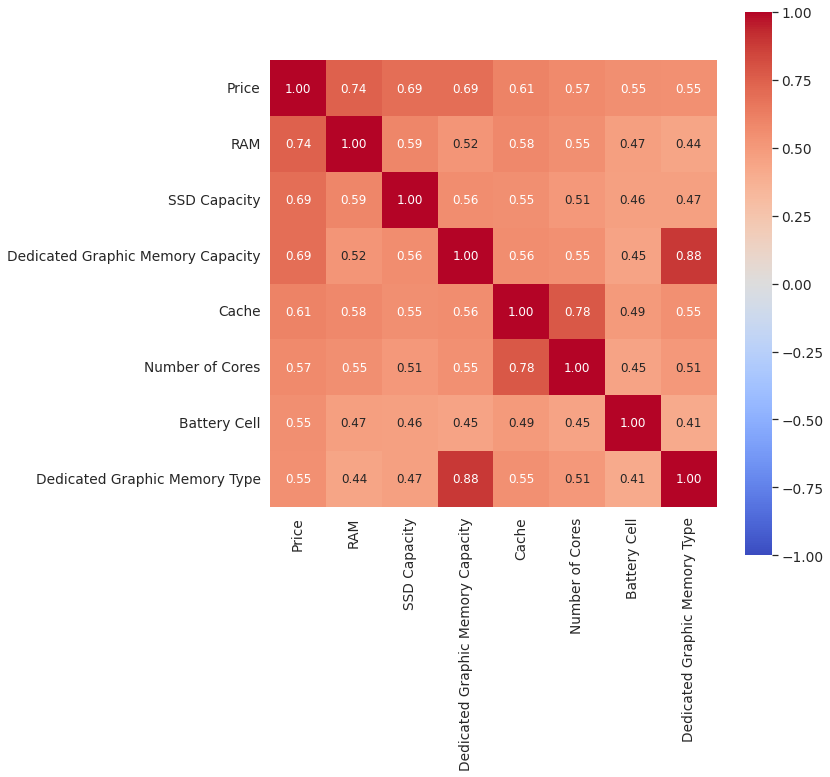

In [145]:
k = 8
corrmat = data.corr()
cols = corrmat.nlargest(k, 'Price')['Price'].index.tolist()
cols
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

In [146]:
remap={'RedmiBook':'Mi','lenovo':'Lenovo'}
data["Vendor"]=data["Vendor"].replace(remap)

In [147]:
data_vendor=data.copy(deep=True)

In [148]:
data_object_cols=[]
for col in data.columns:
    if data[col].dtype==object:
        data_object_cols.append(col)


In [149]:
def encode_func(data, enc, cols = data_object_cols):
  data_enc = data.copy()
  data_enc[cols]= enc.fit_transform(data_enc[cols])
  return data_enc
results = {}
#Качество будем оценивать по R2,MAE,RMSE мерам.
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

def evaluate_encoding(data_enc):
  result = {}
  linear = LinearRegression()
  standart_scaler = StandardScaler()
  robust_scaler = RobustScaler()
  for scaler in standart_scaler,robust_scaler:
    scaled_data = scaler.fit_transform(data_enc.drop('Price', axis = 1))
    linear_r2 = np.mean(cross_val_score(linear, scaled_data, y = data_enc.Price, cv = 5, scoring = 'r2'))
    linear_mse = np.mean(cross_val_score(linear, scaled_data, y = data_enc.Price, cv = 5, scoring = 'neg_mean_absolute_error'))
    linear_rmse = np.mean(cross_val_score(linear, scaled_data, y = data_enc.Price, cv = 5, scoring = 'neg_root_mean_squared_error'))
    result[type(scaler).__name__+'_r2']=linear_r2
    result[type(scaler).__name__+'_mse']=linear_mse
    result[type(scaler).__name__+'_rmse']=linear_rmse
  return result

In [150]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
data_enc = encode_func(data, enc)
results['Ordinal_encoding']=dict(evaluate_encoding(data_enc))

from category_encoders import CountEncoder
enc = CountEncoder()
data_enc = encode_func(data, enc)
results['Count_encoding'] = evaluate_encoding(data_enc)

for col in data_object_cols:
    data_enc[col] = data_enc[col]/data.shape[0]
results['Frequency_encoding'] = evaluate_encoding(data_enc)

pd.DataFrame(results)

,Ordinal_encoding,Count_encoding,Frequency_encoding
StandardScaler_r2,0.73,0.73,0.73
StandardScaler_mse,"-12,119.48","-12,494.89","-12,494.89"
StandardScaler_rmse,"-18,368.29","-18,360.17","-18,360.17"
RobustScaler_r2,0.73,0.73,0.73
RobustScaler_mse,"-12,119.48","-12,494.89","-12,494.89"
RobustScaler_rmse,"-18,368.29","-18,360.17","-18,360.17"


In [151]:
price_data=data.copy(deep=True)
price_data[data_object_cols]= OrdinalEncoder().fit_transform(price_data[data_object_cols])
X_train, X_test, y_train, y_test = train_test_split(price_data.drop('Price', axis=1), price_data.Price, \
                                                    test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [152]:
def check_regressor(data,col,model):
    answers={}
    price_data=data.copy(deep=True)
    price_data[data_object_cols]= OrdinalEncoder().fit_transform(price_data[data_object_cols])
    X_train, X_test, answers["y_train"], answers["y_test"] = train_test_split(price_data.drop(col, axis=1), price_data[col], \
                                                        test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, answers["y_train"])
    
    answers["y_test_pred"] = model.predict(X_test)
    answers["y_train_pred"] = model.predict(X_train)
    return answers
    



In [153]:
def print_mse_rmse(answers):
    errors={}
    errors["Test MSE "]=mean_squared_error(answers["y_test"], answers["y_test_pred"])
    print("Test MSE = %.4f" % errors["Test MSE "])
    errors["Train MSE"]=mean_squared_error(answers["y_train"], answers["y_train_pred"])
    print("Train MSE = %.4f" % errors["Train MSE"])
    errors["Test RMSE"]=mean_squared_error(answers["y_test"], answers["y_test_pred"],squared=False)
    print("Test RMSE = %.4f" % errors["Test RMSE"])
    errors["Train RMSE"]=mean_squared_error(answers["y_train"], answers["y_train_pred"],squared=False)
    print("Train RMSE = %.4f" % errors["Train RMSE"])
    errors["Train MAE"]=mean_absolute_error(answers["y_train"], answers["y_train_pred"])
    print("Train MAE = %.4f" % errors["Train MAE"])
    errors["Test MAE"]=mean_absolute_error(answers["y_test"], answers["y_test_pred"])
    print("Test MAE = %.4f" % errors["Test MAE"])
    return errors
    


In [154]:
print_mse_rmse(check_regressor(data,"Price",LinearRegression()))

Test MSE = 400065795.8990
Train MSE = 251311555.6316
Test RMSE = 20001.6448
Train RMSE = 15852.8091
Train MAE = 10138.4685
Test MAE = 12151.6186


{'Test MSE ': 400065795.8990325,
 'Train MSE': 251311555.63159356,
 'Test RMSE': 20001.64482983918,
 'Train RMSE': 15852.80907699306,
 'Train MAE': 10138.468501400086,
 'Test MAE': 12151.618573839925}

<AxesSubplot:>

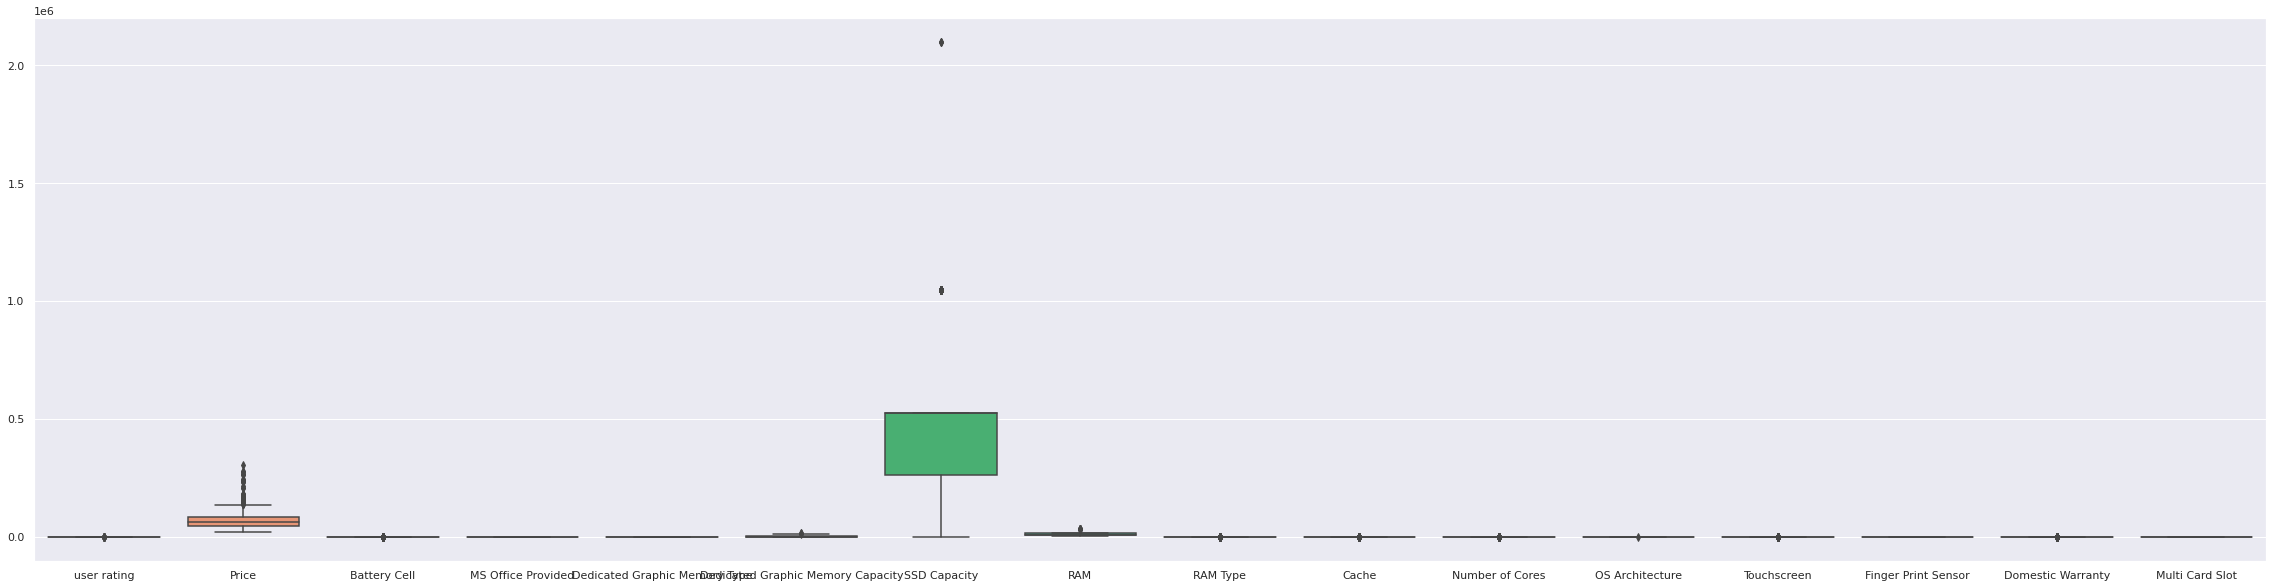

In [155]:
sns.set(rc={'figure.figsize':(40,10)})
sns.boxplot(data=data)

<AxesSubplot:>

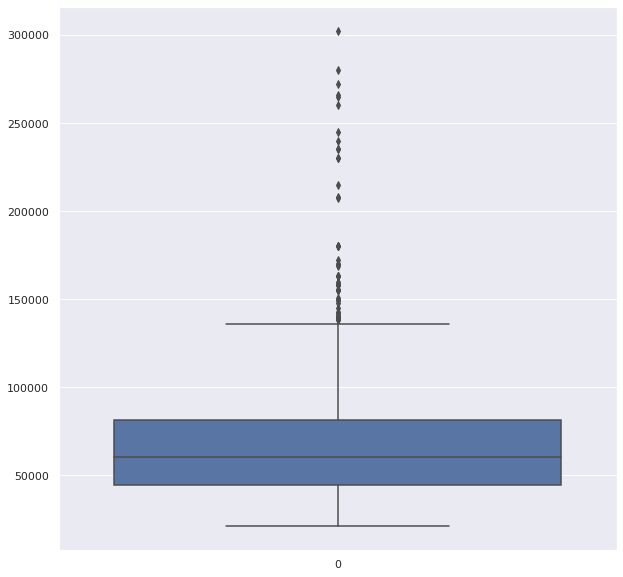

In [156]:
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(data=data["Price"])

<AxesSubplot:>

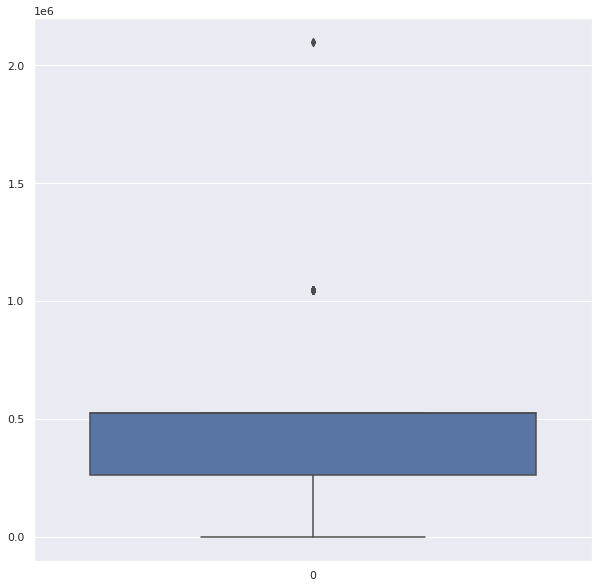

In [157]:
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(data=data["SSD Capacity"])

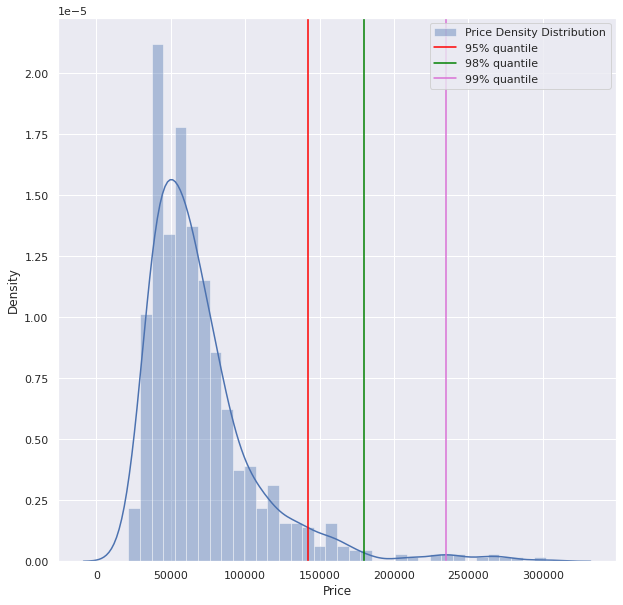

In [158]:
sns.distplot(data['Price'], label='Price Density Distribution')
plt.axvline(data.Price.quantile(0.95), label='95% quantile', c='red')
plt.axvline(data.Price.quantile(0.98), label='98% quantile', c='green')
plt.axvline(data.Price.quantile(0.99), label='99% quantile', c='orchid')
plt.legend()
plt.show()

In [159]:
data=data.loc[data.Price<data.Price.quantile(0.98)]
data.shape

(805, 32)

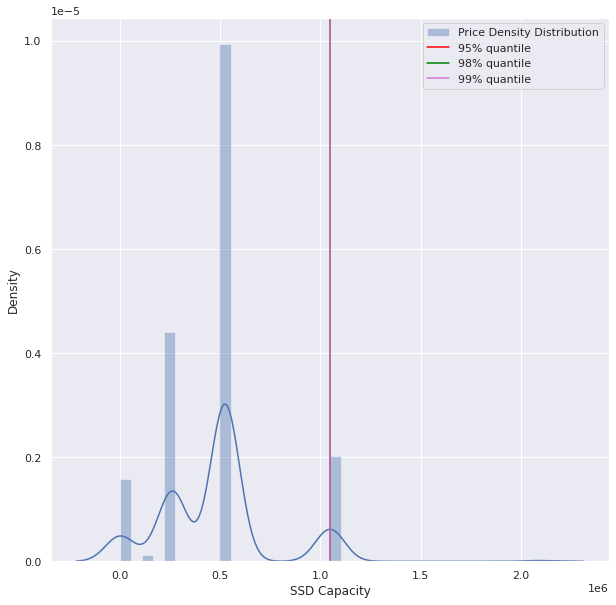

In [160]:
sns.distplot(data["SSD Capacity"], label='Price Density Distribution')
plt.axvline(data["SSD Capacity"].quantile(0.95), label='95% quantile', c='red')
plt.axvline(data["SSD Capacity"].quantile(0.98), label='98% quantile', c='green')
plt.axvline(data["SSD Capacity"].quantile(0.99), label='99% quantile', c='orchid')
plt.legend()
plt.show()

In [161]:
print_mse_rmse(check_regressor(data,"Price",LinearRegression()))

Test MSE = 132352470.5110
Train MSE = 159523837.0224
Test RMSE = 11504.4544
Train RMSE = 12630.2746
Train MAE = 8845.2539
Test MAE = 8826.7935


{'Test MSE ': 132352470.51102643,
 'Train MSE': 159523837.0223874,
 'Test RMSE': 11504.454376937067,
 'Train RMSE': 12630.274621811965,
 'Train MAE': 8845.253942882637,
 'Test MAE': 8826.793462062009}

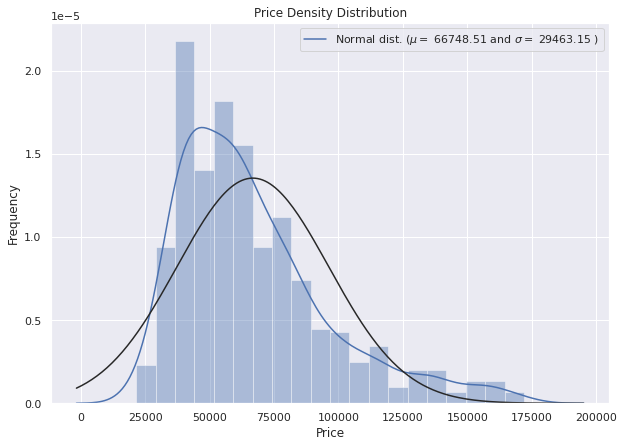

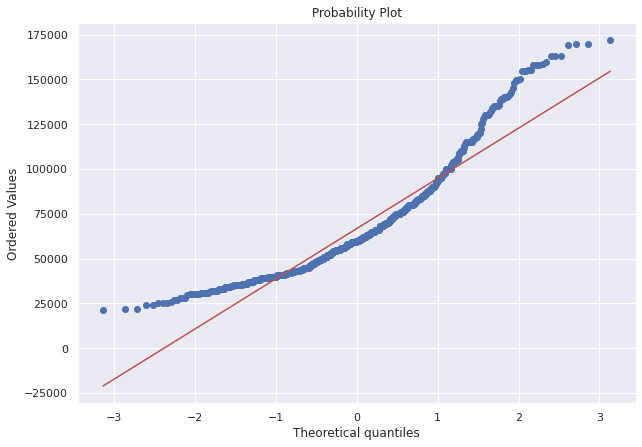

In [162]:
from scipy import stats
from scipy.stats import norm

plt.figure(figsize=(10,7))
sns.distplot(data.Price, fit=norm)

# фитим распределение
(mu, sigma) = norm.fit(data.Price)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Price Density Distribution')

plt.figure(figsize=(10,7))
stats.probplot(data['Price'], plot=plt)
plt.show()

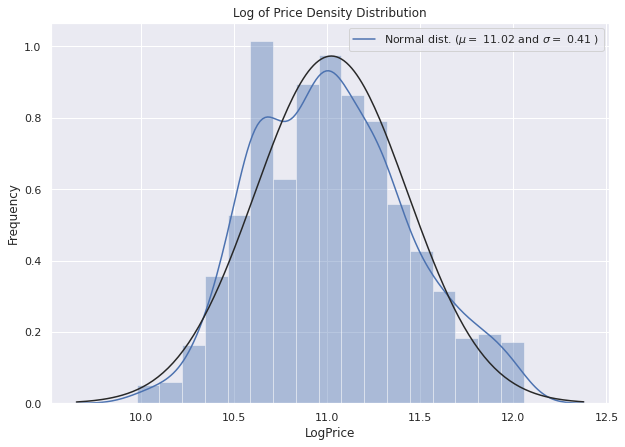

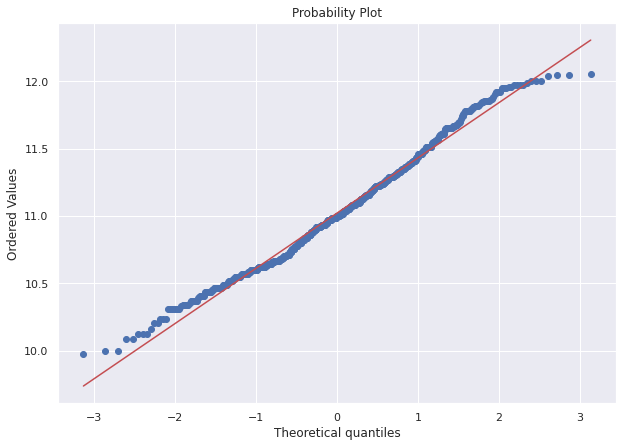

In [163]:
# берем логарифм от цены
data['LogPrice'] = np.log1p(data.Price)

plt.figure(figsize=(10,7))
sns.distplot(data.LogPrice, fit=norm)

# фитим распределение на логарифм от цены
(mu, sigma) = norm.fit(data.LogPrice)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Log of Price Density Distribution')

plt.figure(figsize=(10,7))
stats.probplot(data.LogPrice, plot=plt)
plt.show()

In [164]:
def deLogAnswer(answers):
    answers["y_test"]=np.expm1(answers["y_test"])
    answers["y_train"]=np.expm1(answers["y_train"])
    answers["y_test_pred"]=np.expm1(answers["y_test_pred"])
    answers["y_train_pred"]=np.expm1(answers["y_train_pred"])

    return answers

In [165]:
log_price_data=data.copy(deep=True)
log_price_data=log_price_data.drop("Price",axis=1)
data=data.drop("LogPrice",axis=1)

In [166]:
regressions={}

In [167]:
regressions["LinearRegression"]=print_mse_rmse(check_regressor(data,"Price",LinearRegression()))

Test MSE = 132352470.5110
Train MSE = 159523837.0224
Test RMSE = 11504.4544
Train RMSE = 12630.2746
Train MAE = 8845.2539
Test MAE = 8826.7935


In [168]:
answ=check_regressor(log_price_data,"LogPrice",LinearRegression())
regressions["Log_LinearRegression"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 173614879.8353
Train MSE = 192730846.9899
Test RMSE = 13176.2999
Train RMSE = 13882.7536
Train MAE = 9006.2194
Test MAE = 9378.1307


In [169]:
regressions["Ridge"]=print_mse_rmse(check_regressor(data,"Price",Ridge(alpha = 100)))

Test MSE = 143086372.8596
Train MSE = 168455315.7788
Test RMSE = 11961.8716
Train RMSE = 12979.0337
Train MAE = 8980.8948
Test MAE = 9117.0379


In [170]:
answ=check_regressor(log_price_data,"LogPrice",Ridge(alpha = 100))
regressions["Log_Ridge"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 163763569.7234
Train MSE = 191924272.6812
Test RMSE = 12797.0141
Train RMSE = 13853.6736
Train MAE = 8834.6648
Test MAE = 9080.3825


In [171]:
regressions["Lasso"]=print_mse_rmse(check_regressor(data,"Price",Lasso(alpha = 100)))

Test MSE = 132224335.6972
Train MSE = 160259866.3074
Test RMSE = 11498.8841
Train RMSE = 12659.3786
Train MAE = 8840.6569
Test MAE = 8814.4873


In [172]:
answ=check_regressor(log_price_data,"LogPrice",Lasso(alpha = 100))
regressions["Log_Lasso"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 912177397.7161
Train MSE = 895213650.9027
Test RMSE = 30202.2747
Train RMSE = 29920.1212
Train MAE = 21881.4583
Test MAE = 21831.0296


In [173]:
regressions["ElasticNet"]=print_mse_rmse(check_regressor(data,"Price",ElasticNet(alpha = 0.5,  l1_ratio= 0.5)))

Test MSE = 145674576.9187
Train MSE = 171576787.0157
Test RMSE = 12069.5724
Train RMSE = 13098.7323
Train MAE = 9030.8146
Test MAE = 9183.2668


In [174]:
answ=check_regressor(log_price_data,"LogPrice",ElasticNet(alpha = 0.5,  l1_ratio= 0.5))
regressions["Log_ElasticNet"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 785220965.6902
Train MSE = 766894963.8863
Test RMSE = 28021.7945
Train RMSE = 27692.8685
Train MAE = 20012.8166
Test MAE = 19931.0043


In [175]:
regressions["GradientBoostingRegressor"]=print_mse_rmse(check_regressor(data,"Price",GradientBoostingRegressor(n_estimators=200, max_depth=3)))

Test MSE = 91067117.5823
Train MSE = 19175660.3394
Test RMSE = 9542.9093
Train RMSE = 4379.0022
Train MAE = 3300.0487
Test MAE = 6333.5689


In [176]:
answ=check_regressor(log_price_data,"LogPrice",GradientBoostingRegressor(n_estimators=200, max_depth=3))
regressions["Log_GradientBoostingRegressor"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 76519915.0839
Train MSE = 21080665.5486
Test RMSE = 8747.5662
Train RMSE = 4591.3686
Train MAE = 3222.2049
Test MAE = 5887.2508


In [177]:
regressions["LGBMRegressor"]=print_mse_rmse(check_regressor(data,"Price",LGBMRegressor(n_estimators=200, max_depth=3)))

Test MSE = 78372726.5364
Train MSE = 39226109.1144
Test RMSE = 8852.8372
Train RMSE = 6263.0751
Train MAE = 4386.3073
Test MAE = 6339.4159


In [178]:
answ=check_regressor(log_price_data,"LogPrice",LGBMRegressor(n_estimators=200, max_depth=3))
regressions["Log_LGBMRegressor"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 71517963.2232
Train MSE = 41808698.8545
Test RMSE = 8456.8294
Train RMSE = 6465.9646
Train MAE = 4267.5242
Test MAE = 5912.8258


In [179]:
regressions["CatBoostRegressor"]=print_mse_rmse(check_regressor(data,"Price",CatBoostRegressor(iterations=200, logging_level='Silent', max_depth = 3)))

Test MSE = 82555952.3533
Train MSE = 38874816.2807
Test RMSE = 9086.0306
Train RMSE = 6234.9672
Train MAE = 4748.9935
Test MAE = 6407.8621


In [180]:
answ=check_regressor(log_price_data,"LogPrice",CatBoostRegressor(iterations=200, logging_level='Silent', max_depth = 3))
regressions["Log_CatBoostRegressor"]=print_mse_rmse(deLogAnswer(answ))

Test MSE = 72279382.2804
Train MSE = 44267034.0821
Test RMSE = 8501.7282
Train RMSE = 6653.3476
Train MAE = 4700.6440
Test MAE = 6130.2156


In [181]:
regressionsPD=pd.DataFrame(regressions)
regressionsPD

,LinearRegression,Log_LinearRegression,Ridge,Log_Ridge,Lasso,Log_Lasso,ElasticNet,Log_ElasticNet,GradientBoostingRegressor,Log_GradientBoostingRegressor,LGBMRegressor,Log_LGBMRegressor,CatBoostRegressor,Log_CatBoostRegressor
Test MSE,"132,352,470.51","173,614,879.84","143,086,372.86","163,763,569.72","132,224,335.70","912,177,397.72","145,674,576.92","785,220,965.69","91,067,117.58","76,519,915.08","78,372,726.54","71,517,963.22","82,555,952.35","72,279,382.28"
Train MSE,"159,523,837.02","192,730,846.99","168,455,315.78","191,924,272.68","160,259,866.31","895,213,650.90","171,576,787.02","766,894,963.89","19,175,660.34","21,080,665.55","39,226,109.11","41,808,698.85","38,874,816.28","44,267,034.08"
Test RMSE,"11,504.45","13,176.30","11,961.87","12,797.01","11,498.88","30,202.27","12,069.57","28,021.79","9,542.91","8,747.57","8,852.84","8,456.83","9,086.03","8,501.73"
Train RMSE,"12,630.27","13,882.75","12,979.03","13,853.67","12,659.38","29,920.12","13,098.73","27,692.87","4,379.00","4,591.37","6,263.08","6,465.96","6,234.97","6,653.35"
Train MAE,"8,845.25","9,006.22","8,980.89","8,834.66","8,840.66","21,881.46","9,030.81","20,012.82","3,300.05","3,222.20","4,386.31","4,267.52","4,748.99","4,700.64"
Test MAE,"8,826.79","9,378.13","9,117.04","9,080.38","8,814.49","21,831.03","9,183.27","19,931.00","6,333.57","5,887.25","6,339.42","5,912.83","6,407.86","6,130.22"


In [182]:
data_object_cols=[]
for col in data.columns:
    if data[col].dtype==object and col!="Vendor":
        data_object_cols.append(col)
enc=OrdinalEncoder()
data_vendor[data_object_cols]= enc.fit_transform(data_vendor[data_object_cols])

In [183]:
def check_classifier(data,col,model):
    answers={}
    vendor_data=data.copy(deep=True)
    vendor_data[data_object_cols]= OrdinalEncoder().fit_transform(vendor_data[data_object_cols])
    X_train, X_test, answers["y_train"], answers["y_test"] = train_test_split(vendor_data.drop(col, axis=1), vendor_data[col], \
                                                        test_size=0.33, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, answers["y_train"])
    
    answers["y_test_pred"] = model.predict(X_test)
    answers["y_train_pred"] = model.predict(X_train)
    return answers
    

In [184]:



from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score


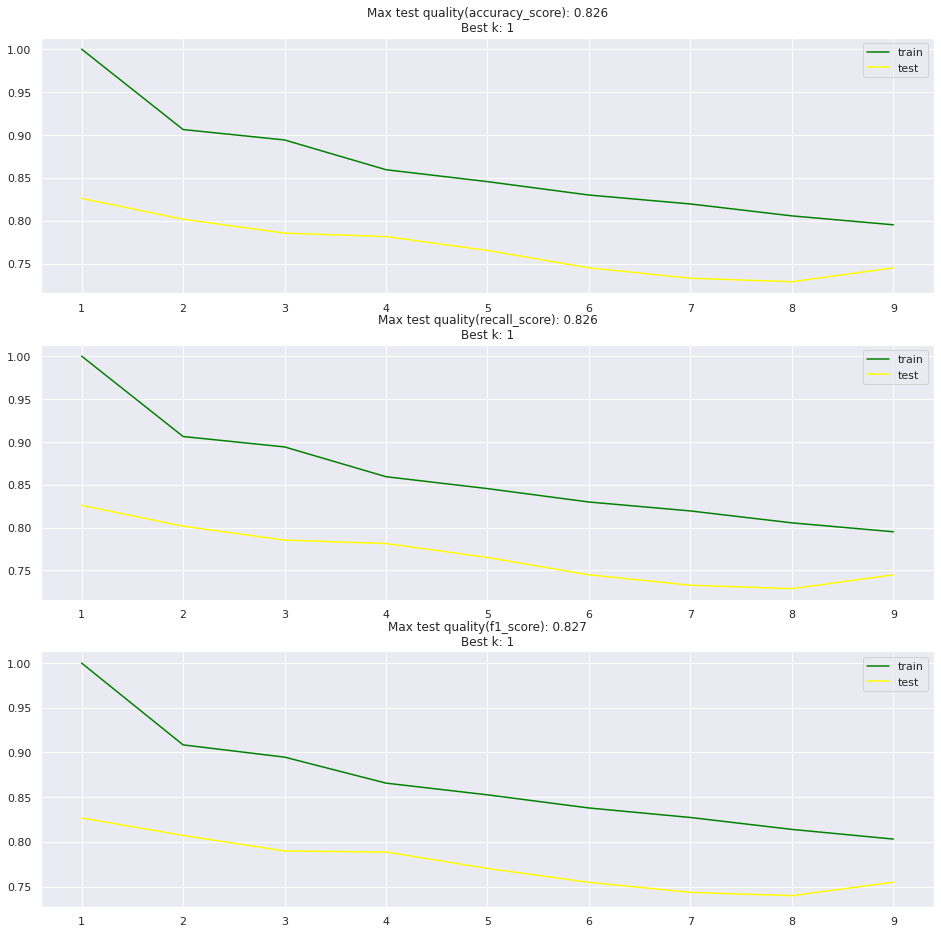

In [185]:
X_train_v, X_test_v, y_train, y_test = train_test_split(
    data_vendor.drop(['Vendor'], axis=1), data_vendor['Vendor'], test_size=0.30, random_state=42, stratify=data_vendor['Vendor']
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_v)
X_test_scaled = scaler.transform(X_test_v)
neighbors = range(1, 10)
f1_score_train = []
f1_score_test = []
accuracy_score_train = []
accuracy_score_test = []
recall_score_train = []
recall_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train,average='weighted'))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test,average='weighted'))
    accuracy_score_train.append(accuracy_score(knn.predict(X_train_scaled), y_train))
    accuracy_score_test.append(accuracy_score(knn.predict(X_test_scaled), y_test))
    recall_score_train.append(recall_score(knn.predict(X_train_scaled), y_train,average='weighted'))
    recall_score_test.append(recall_score(knn.predict(X_test_scaled), y_test,average='weighted'))
fig, axs = plt.subplots(3, 1, figsize=(16, 16))
axs[0].set_title("Max test quality(accuracy_score): {:.3f}\nBest k: {}".format(max(accuracy_score_test), np.argmax(accuracy_score_test)+1))
axs[0].plot(neighbors, accuracy_score_train, color='green', label='train')
axs[0].plot(neighbors, accuracy_score_test, color='yellow', label='test')
axs[0].legend()

axs[1].set_title("Max test quality(recall_score): {:.3f}\nBest k: {}".format(max(recall_score_test), np.argmax(recall_score_test)+1))
axs[1].plot(neighbors, recall_score_train, color='green', label='train')
axs[1].plot(neighbors, recall_score_test, color='yellow', label='test')
axs[1].legend();  

axs[2].set_title("Max test quality(f1_score): {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
axs[2].plot(neighbors, f1_score_train, color='green', label='train')
axs[2].plot(neighbors, f1_score_test, color='yellow', label='test')
axs[2].legend();  

In [186]:
def print_classifier(answers):
    metrics={}
    metrics["f1_score_train"]=f1_score(answers["y_train"], answers["y_train_pred"],average='weighted')
    print(metrics["f1_score_train"])
    metrics["f1_score_test"]=f1_score(answers["y_test"], answers["y_test_pred"],average='weighted')
    print(metrics["f1_score_test"])
    metrics["accuracy_score_train"]=accuracy_score(answers["y_train"], answers["y_train_pred"])
    print(metrics["accuracy_score_train"])
    metrics["accuracy_score_test"]=accuracy_score(answers["y_test"], answers["y_test_pred"])
    print(metrics["accuracy_score_test"])
    metrics["recall_score_train"]=recall_score(answers["y_train"], answers["y_train_pred"],average='weighted')
    print(metrics["recall_score_train"])
    metrics["recall_score_test"]=recall_score(answers["y_test"], answers["y_test_pred"],average='weighted')
    print(metrics["recall_score_test"])
    return metrics

In [187]:
classifications={}

In [188]:

classifications["KNeighborsClassifier"]=print_classifier(check_classifier(data_vendor,"Vendor",KNeighborsClassifier(n_neighbors=1)))

1.0
0.7892911799665414
1.0
0.7977941176470589
1.0
0.7977941176470589


In [189]:
classifications["GradientBoostingClassifier"]=print_classifier(check_classifier(data_vendor,"Vendor",GradientBoostingClassifier(n_estimators=200, max_depth=3)))

1.0
0.8849867333324322
1.0
0.8860294117647058
1.0
0.8860294117647058


In [190]:
classifications["GradientBoostingClassifier"]=print_classifier(check_classifier(data_vendor,"Vendor",LGBMClassifier(n_estimators=200, max_depth=3)))

1.0
0.8876308083508267
1.0
0.8933823529411765
1.0
0.8933823529411765


In [191]:
classifications["CatBoostClassifier"]=print_classifier(check_classifier(data_vendor,"Vendor",CatBoostClassifier(iterations=200, logging_level='Silent', max_depth = 3)))

0.98909611626071
0.8491409374480895
0.9891107078039928
0.8566176470588235
0.9891107078039928
0.8566176470588235


In [193]:
classificationsPD=pd.DataFrame(classifications)
classificationsPD

,KNeighborsClassifier,GradientBoostingClassifier,CatBoostClassifier
f1_score_train,1.00,1.00,0.99
f1_score_test,0.79,0.89,0.85
accuracy_score_train,1.00,1.00,0.99
accuracy_score_test,0.80,0.89,0.86
recall_score_train,1.00,1.00,0.99
recall_score_test,0.80,0.89,0.86
